In [ ]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


Load images, and reshape them.

In [ ]:
directories = [d for d in os.listdir('images') if os.path.isdir(os.path.join('images', d))]
images_dict = {d: os.listdir(os.path.join('images', d)) for d in directories}
print(images_dict)

# Load all images into a dict
loaded_images = {d: [Image.open(os.path.join('images', d, img)) for img in images_dict[d]] for d in directories}

# Reshape all images
target_size = (256, 256)
reshaped_images = {d: [img.resize(target_size) for img in loaded_images[d]] for d in directories}

reshaped_images["aze_passport"][0].show()

{'aze_passport': ['63.jpg', '77.jpg', '88.jpg', '89.jpg', '76.jpg', '62.jpg', '74.jpg', '60.jpg', '48.jpg', '49.jpg', '61.jpg', '75.jpg', '59.jpg', '71.jpg', '65.jpg', '64.jpg', '70.jpg', '58.jpg', '66.jpg', '72.jpg', '99.jpg', '98.jpg', '73.jpg', '67.jpg', '00.jpg', '14.jpg', '28.jpg', '29.jpg', '15.jpg', '01.jpg', '17.jpg', '03.jpg', '02.jpg', '16.jpg', '12.jpg', '06.jpg', '07.jpg', '13.jpg', '39.jpg', '05.jpg', '11.jpg', '10.jpg', '04.jpg', '38.jpg', '21.jpg', '35.jpg', '09.jpg', '08.jpg', '34.jpg', '20.jpg', '36.jpg', '22.jpg', '23.jpg', '37.jpg', '33.jpg', '27.jpg', '26.jpg', '32.jpg', '18.jpg', '24.jpg', '30.jpg', '31.jpg', '25.jpg', '19.jpg', '42.jpg', '56.jpg', '81.jpg', '95.jpg', '94.jpg', '80.jpg', '57.jpg', '43.jpg', '55.jpg', '41.jpg', '69.jpg', '96.jpg', '82.jpg', '83.jpg', '97.jpg', '68.jpg', '40.jpg', '54.jpg', '78.jpg', '50.jpg', '44.jpg', '93.jpg', '87.jpg', '86.jpg', '92.jpg', '45.jpg', '51.jpg', '79.jpg', '47.jpg', '53.jpg', '84.jpg', '90.jpg', '91.jpg', '85.jpg', '5

Convert images to numpy arrays, and one-hot encode labels.

In [ ]:
all_images = []
all_labels = []
for label, images in reshaped_images.items():
    all_images.extend(images)
    all_labels.extend([label] * len(images))

image_arrays = np.array([np.array(img) for img in all_images])

label_to_int = {label: idx for idx, label in enumerate(set(all_labels))}
label_arrays = np.array([label_to_int[label] for label in all_labels])

print("Image arrays shape:", image_arrays.shape)
print("Label arrays shape:", label_arrays.shape)

Image arrays shape: (1000, 256, 256, 3)
Label arrays shape: (1000,)


Split data into train and holdout.

In [ ]:

train_images, holdout_images, train_labels, holdout_labels = train_test_split(
    image_arrays, label_arrays, test_size=0.5, random_state=42
)

train_images_tensor = torch.tensor(train_images).permute(0, 3, 1, 2).float() / 255.0
holdout_images_tensor = torch.tensor(holdout_images).permute(0, 3, 1, 2).float() / 255.0
train_labels_tensor = torch.tensor(train_labels).long()
holdout_labels_tensor = torch.tensor(holdout_labels).long()

print("Train images tensor shape:", train_images_tensor.shape)
print("Holdout images tensor shape:", holdout_images_tensor.shape)
print("Train labels tensor shape:", train_labels_tensor.shape)
print("Holdout labels tensor shape:", holdout_labels_tensor.shape)

Train images tensor shape: torch.Size([500, 3, 256, 256])
Holdout images tensor shape: torch.Size([500, 3, 256, 256])
Train labels tensor shape: torch.Size([500])
Holdout labels tensor shape: torch.Size([500])


Check the train and holdout datasets aren't missing any classes.

In [ ]:
holdout_labels_tensor.unique(return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([57, 55, 61, 50, 46, 46, 41, 51, 41, 52]))

Define a simple convolutional neural net. The output should sum to 1.0

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

image = reshaped_images['lva_passport'][0]
image_tensor = torch.tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

output = model(image_tensor)
print(output)

tensor([[0.1062, 0.0988, 0.0914, 0.0973, 0.1025, 0.1016, 0.1053, 0.0995, 0.1031,
         0.0942]], grad_fn=<SoftmaxBackward0>)


In [8]:
output.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

Train a model

In [ ]:
num_epochs = 10
batch_size = 32

train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')

Epoch [1/10], Loss: 2.3426
Epoch [2/10], Loss: 2.3423
Epoch [3/10], Loss: 2.3137
Epoch [4/10], Loss: 2.2734
Epoch [5/10], Loss: 2.2390
Epoch [6/10], Loss: 2.1773
Epoch [7/10], Loss: 2.1331
Epoch [8/10], Loss: 2.0611
Epoch [9/10], Loss: 1.9944
Epoch [10/10], Loss: 1.9450


Save the model

In [ ]:
torch.save(model.state_dict(), 'simple_cnn_model.pth')

Evaluate model on holdout dataset

In [ ]:
model.eval()

holdout_outputs = model(holdout_images_tensor)
holdout_loss = criterion(holdout_outputs, holdout_labels_tensor)

_, predicted = torch.max(holdout_outputs, 1)
accuracy = (predicted == holdout_labels_tensor).sum().item() / holdout_labels_tensor.size(0)

print(f'Holdout Loss: {holdout_loss.item():.4f}')
print(f'Holdout Accuracy: {accuracy * 100:.2f}%')

Holdout Loss: 2.1806
Holdout Accuracy: 29.40%


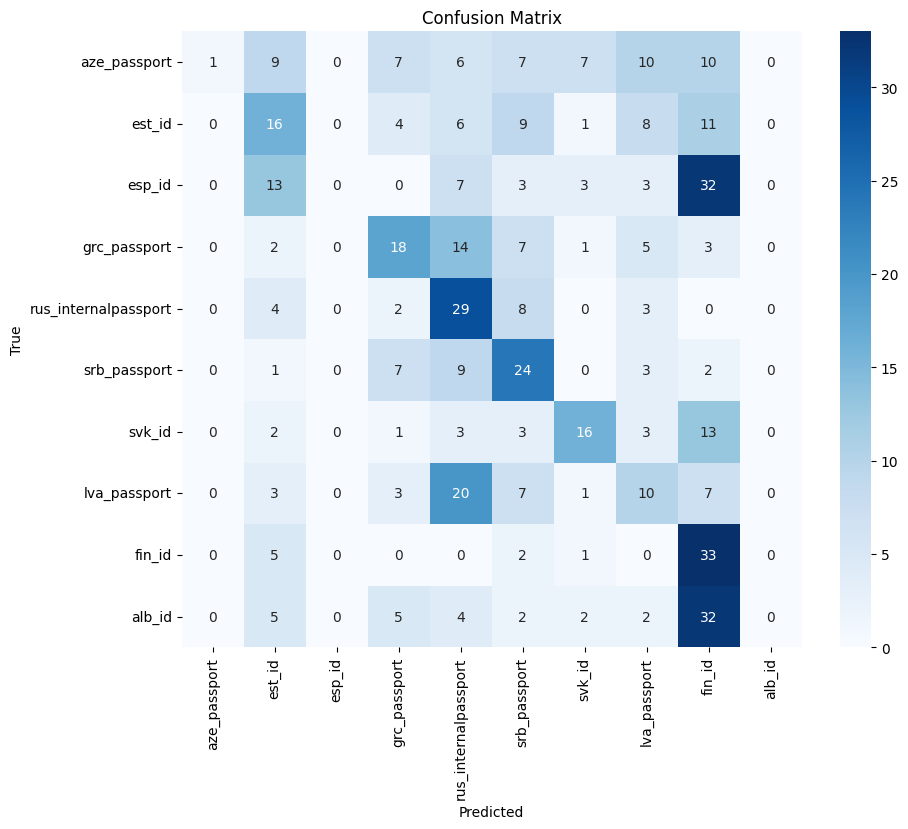

In [ ]:

cm = confusion_matrix(holdout_labels_tensor, predicted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_int.keys(), yticklabels=label_to_int.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()